In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
crypto_currency = 'ETH-USD'

start = dt.datetime(2015, 1, 1)
end = dt.datetime(2023,6,1)

data = yf.download(crypto_currency, start, end)



[*********************100%%**********************]  1 of 1 completed


In [2]:

scaler = MinMaxScaler(feature_range= (0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


Epoch 1/50
56/56 [==============================] - 4s 38ms/step - loss: 0.0294 - val_loss: 0.0103
Epoch 2/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0118 - val_loss: 0.0059
Epoch 3/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 4/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 5/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 6/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 7/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 8/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 9/50
56/56 [==============================] - 2s 31ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 10/50
56/56 [==============================] - 2s 30ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 11/

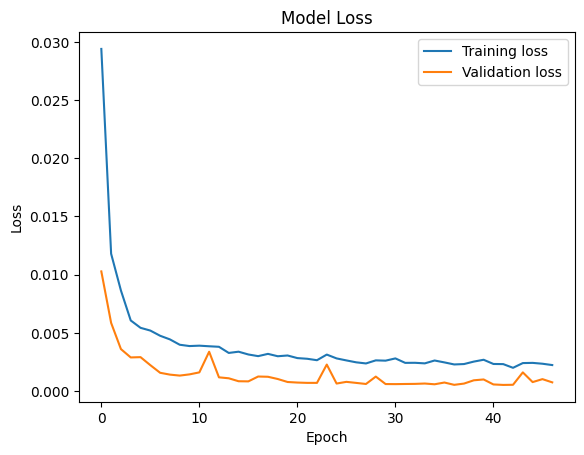

In [3]:
import keras
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
model = keras.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, 
                      input_shape=(x_train.shape[1], 1),
                      kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1))




model.compile(optimizer='adam', loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(x_train, y_train, epochs=50, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[early_stopping])


plt.plot(history.history['loss'], label='Training loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

11/11 [==============================] - 0s 9ms/step


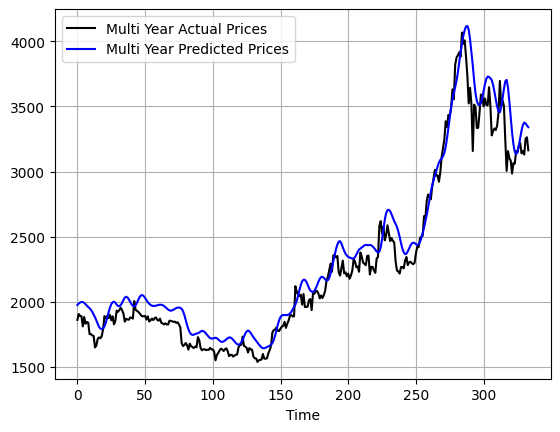

avg distance from actual price [120.628334]
Correct, Wrong and ratio if predicting price is up every day 171 162 0.5135135135135135
overall correct: 175 overall wrong: 158
longest overall correct streak: 8 longest overall wrong streak: 6
explained variance score: 0.9691629295213327
prediction window: 60


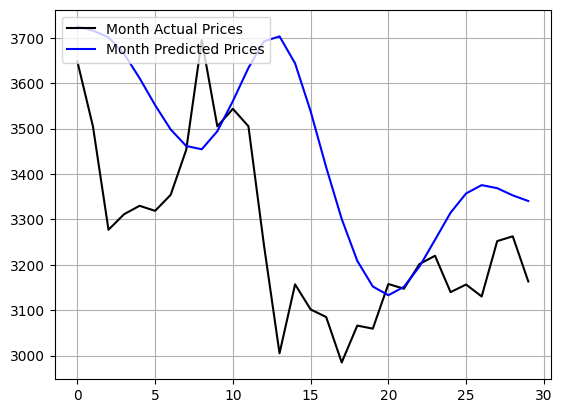

correct: 16 wrong: 13
longest correct streak: 5 longest wrong streak: 3



In [6]:

test_start = dt.datetime(2023,6,1)
test_end = dt.datetime.now()

test_data = yf.download(crypto_currency, test_start, test_end)

actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

prediction_month = prediction_prices[-30:]
actual_month = actual_prices[-30:]

plt.plot(actual_prices, color = 'black', label = 'Multi Year Actual Prices')
plt.plot(prediction_prices, color = 'blue', label = 'Multi Year Predicted Prices')
plt.xlabel('Time')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
up = 0
down = 0
avg = 0
baseline=0
base = []
for i in range(len(prediction_prices)):
    if i != 0:
        base.append(actual_prices[i - 1])
        avg += abs(prediction_prices[i] - actual_prices[i])
        if actual_prices[i] > actual_prices[i- 1]:
            baseline += abs(actual_prices[i-1]-actual_prices[i])
            up += 1
        else:
            down += 1
        if actual_prices[i - 1] > prediction_prices[i] and actual_prices[i - 1] > actual_prices[i]:
            correct += 1
            a = 1
        elif actual_prices[i - 1] < prediction_prices[i] and actual_prices[i - 1] < actual_prices[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
#print("baseline avg distance from actual price", baseline/len(prediction_prices))           
print("avg distance from actual price", avg/len(prediction_prices))        
print("Correct, Wrong and ratio if predicting price is up every day", up, down, up/(down + up))    
print("overall correct:", correct, "overall wrong:", wrong)
print("longest overall correct streak:", longc_streak, "longest overall wrong streak:", longw_streak)
from sklearn.metrics import explained_variance_score
y_true = actual_prices
y_pred = prediction_prices
print("explained variance score:", explained_variance_score(y_true, y_pred))
print("prediction window:", prediction_days)

plt.plot(actual_month, color = 'black', label = 'Month Actual Prices')
plt.plot(prediction_month, color = 'blue', label = 'Month Predicted Prices')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

correct = 0
wrong = 0
longc_streak = 0
longw_streak = 0
c_streak = 0
w_streak = 0
a = -1
for i in range(len(prediction_month)):
    if i != 0:
        if actual_month[i - 1] > prediction_month[i] and actual_month[i - 1] > actual_month[i]:
            correct += 1
            a = 1
        elif actual_month[i - 1] < prediction_month[i] and actual_month[i - 1] < actual_month[i]:
            correct += 1
            a = 1
        else: 
            wrong += 1
            a = 0
    if a == 1:
        c_streak += 1
        w_streak = 0
        if c_streak > longc_streak:
            longc_streak = c_streak
    if a == 0:
        w_streak += 1
        c_streak = 0
        if w_streak > longw_streak:
            longw_streak = w_streak
        
    
print("correct:", correct, "wrong:", wrong)
print("longest correct streak:", longc_streak, "longest wrong streak:", longw_streak)
print()

